# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1am9IfpbH0NjO_OogizPYbIux99iMJZmm?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:10<00:00, 15.6MB/s]


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

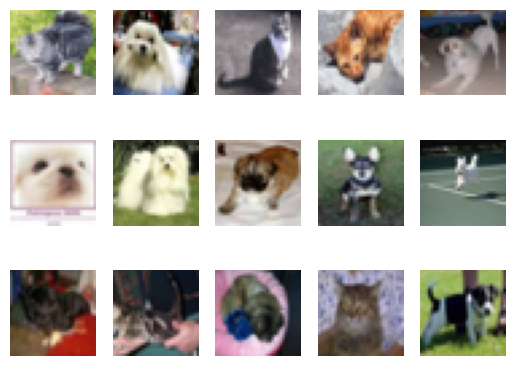

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [6]:
num_train = len(train_loader.sampler)
num_val = len(val_loader.sampler)
num_test = len(test_loader.sampler)

print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")
print(f"Number of test examples: {num_test}")


Number of training examples: 8000
Number of validation examples: 2000
Number of test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We use a validation set to check how well our model works on data it hasn’t seen before. This helps us know if the model is truly learning or just memorizing the training examples.

If we only look at the training loss or error, the model might look like it's doing really well, but that’s just because it has seen those examples many times. It might not do well on new data.

By using a validation set, we can check if the model is learning in a way that works for other data too. This helps us find the best version of the model before we test it on the final test set.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. **Measuring the number of parameters in a network is
one way of measuring the "size" of a network.**

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [10]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


1. torch.Size([5, 3, 3, 3])  ->  5×3×3×3=135
2. torch.Size([5])   -> 5
3. torch.Size([1, 245])   -> 1×245=245
4. torch.Size([1])     -> 1

Total parameters in small_net = 135+5+245+1 = 386

In [11]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


1. torch.Size([5, 3, 5, 5])    -> 5×3×5×5 = 375
2. torch.Size([5])
3. torch.Size([10, 5, 5, 5])   -> 10×5×5×5=1250
4. torch.Size([10])
5. torch.Size([32, 250])   -> 32×250=8000
6. torch.Size([32])
7. torch.Size([1, 32])
8. torch.Size([1])

Total parameters in large_net = 375+5+1250+10+8000+32+32+1 = 9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [14]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

From the function header, `def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30)`, the default values are:

batch_size = 64

learning_rate = 0.01

num_epochs = 30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

There are 2 types of file being written:

1. Model checkpoint files

model_small_bs64_lr0.01_epoch0  
model_small_bs64_lr0.01_epoch1  
model_small_bs64_lr0.01_epoch2  
model_small_bs64_lr0.01_epoch3  
model_small_bs64_lr0.01_epoch4  

Each file stores the trained model’s weights at the end of that epoch.

2. Training and validation logs

model_small_bs64_lr0.01_epoch4_train_err.csv  
model_small_bs64_lr0.01_epoch4_train_loss.csv  
model_small_bs64_lr0.01_epoch4_val_err.csv  
model_small_bs64_lr0.01_epoch4_val_loss.csv  

These files record the training and validation error/loss values for each of the 5 epochs.



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [16]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
train_net(small_net)
train_net(large_net)

Epoch 1: Train err: 0.428625, Train loss: 0.6738233604431152 |Validation err: 0.375, Validation loss: 0.6535940486937761
Epoch 2: Train err: 0.368375, Train loss: 0.6462161011695862 |Validation err: 0.388, Validation loss: 0.6617616061121225
Epoch 3: Train err: 0.35425, Train loss: 0.6323772382736206 |Validation err: 0.345, Validation loss: 0.6258879546076059
Epoch 4: Train err: 0.339, Train loss: 0.6151759381294251 |Validation err: 0.351, Validation loss: 0.6236053146421909
Epoch 5: Train err: 0.32625, Train loss: 0.6051906929016113 |Validation err: 0.335, Validation loss: 0.6171115264296532
Epoch 6: Train err: 0.31625, Train loss: 0.5947989821434021 |Validation err: 0.3305, Validation loss: 0.611322795972228
Epoch 7: Train err: 0.316625, Train loss: 0.5898247981071472 |Validation err: 0.3325, Validation loss: 0.6088564712554216
Epoch 8: Train err: 0.3085, Train loss: 0.5847564363479614 |Validation err: 0.319, Validation loss: 0.607175450772047
Epoch 9: Train err: 0.306375, Train loss

Total time elapsed:

- small_net: 130.61 seconds
- large_net: 142.81 seconds

`large_net` took longer to train because it has more layers and more parameters. This makes each forward and backward pass slower, since it has to perform more calculations to update the model.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

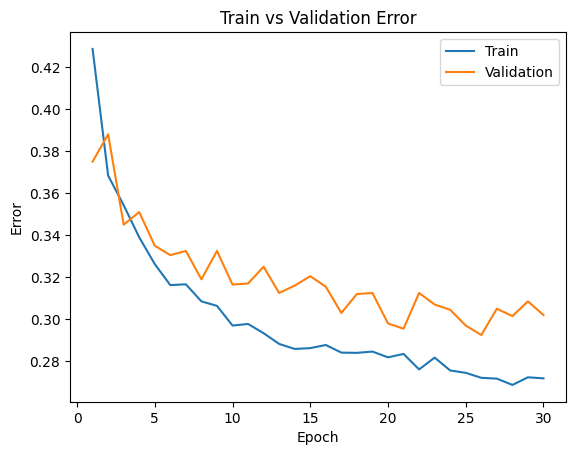

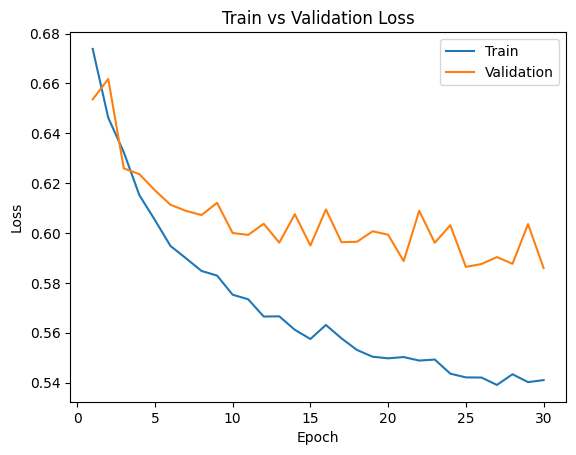

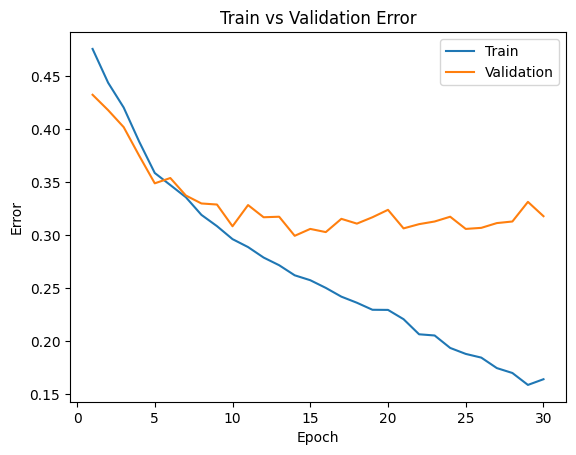

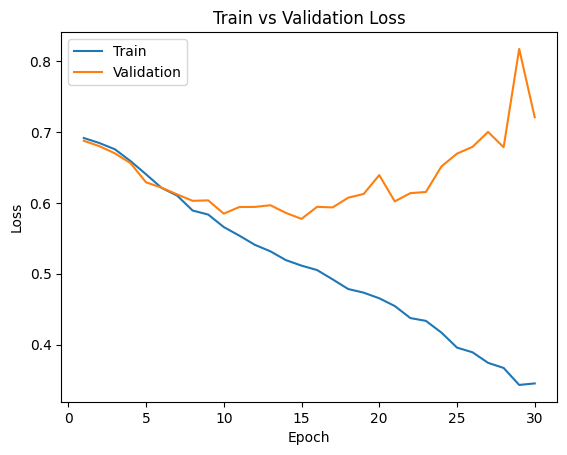

In [18]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_path)

large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

- small_net shows signs of underfitting.

- large_net shows signs of overfitting.


For small_net, both training and validation error/loss decrease steadily at first, then level off. The gap between the curves remains small, suggesting that the model is not overfitting much. However, both errors remain relatively high, indicating that small_net might be underfitting — it may not have enough capacity to fully learn the task.

For large_net, training error and loss drop much lower than in small_net, showing that it learns the training data better. However, after about epoch 15, the validation loss increases while training loss continues to drop, and a noticeable gap appears between the validation and training curves. This is a sign of overfitting — the model is learning the training data too well but not generalizing to new data.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [19]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 0.4115, Validation loss: 0.6831991244107485
Epoch 9: Train err: 0.424375, Tr

Total time elapsed: 143.97 seconds

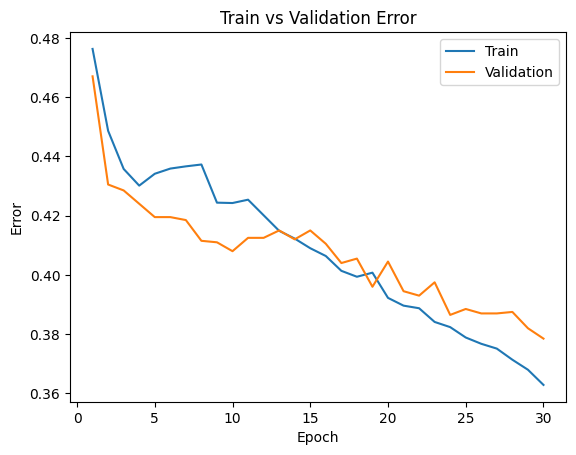

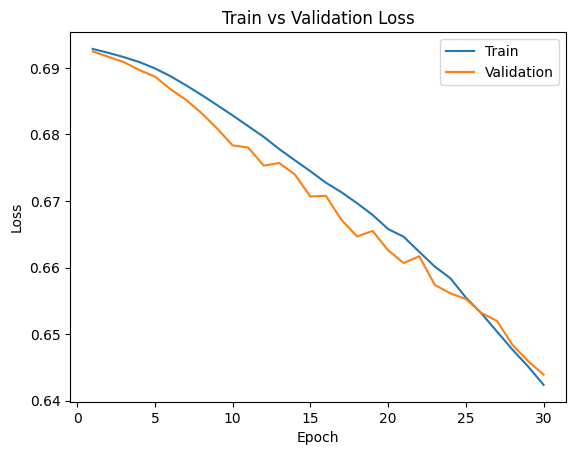

In [20]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)


Lowering the learning rate from 0.01 to 0.001 slightly increased training time, making the model learn more slowly. The training and validation curves became smoother and less steep, meaning the model updated its weights in smaller steps. This can help avoid overshooting and make training more stable, but it also means the model needs more epochs to reach low error/loss.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [22]:
large_net=LargeNet()
train_net(large_net, learning_rate=0.1)


Epoch 1: Train err: 0.420875, Train loss: 0.6701756777763367 |Validation err: 0.3535, Validation loss: 0.6296987608075142
Epoch 2: Train err: 0.3585, Train loss: 0.6298667473793029 |Validation err: 0.3555, Validation loss: 0.6279063336551189
Epoch 3: Train err: 0.342, Train loss: 0.6152220315933228 |Validation err: 0.315, Validation loss: 0.6184257734566927
Epoch 4: Train err: 0.330125, Train loss: 0.6025240204334259 |Validation err: 0.3145, Validation loss: 0.5939192408695817
Epoch 5: Train err: 0.321625, Train loss: 0.5904353885650635 |Validation err: 0.315, Validation loss: 0.5876242332160473
Epoch 6: Train err: 0.299375, Train loss: 0.569568902015686 |Validation err: 0.3045, Validation loss: 0.611666907556355
Epoch 7: Train err: 0.2985, Train loss: 0.5723032224178314 |Validation err: 0.348, Validation loss: 0.616845678538084
Epoch 8: Train err: 0.290875, Train loss: 0.5583203547000885 |Validation err: 0.329, Validation loss: 0.6099908705800772
Epoch 9: Train err: 0.284, Train loss:

Total time elapsed: 141.04 seconds

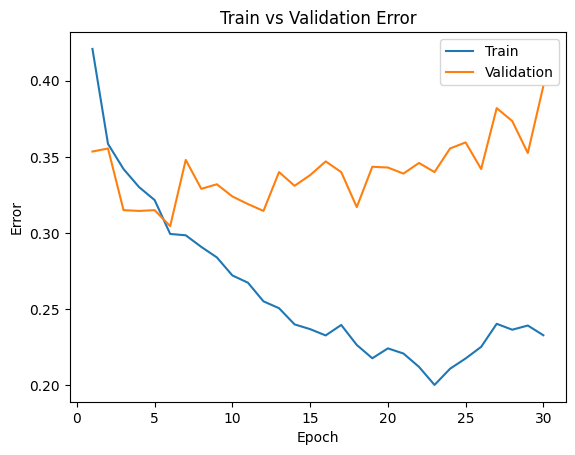

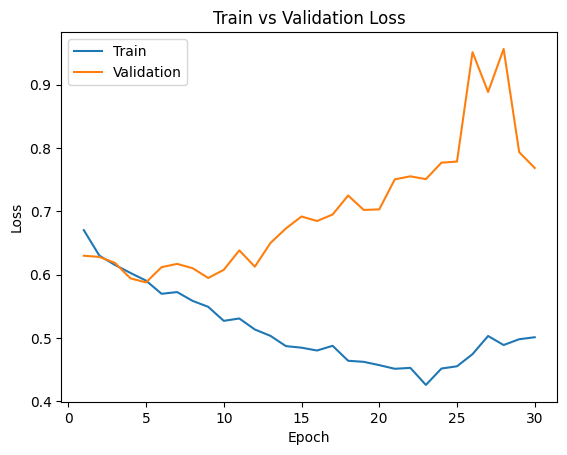

In [23]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)


Increasing the learning rate to 0.1 made the model learn faster in the beginning, but the training became less stable. From the plots, the training loss and error decreased steadily, but the validation loss increased over time, and validation error fluctuated and worsened in later epochs. This is a sign of overfitting and instability, likely due to overshooting the optimal weights.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [24]:
large_net=LargeNet()
train_net(large_net, batch_size=512)

Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Validation loss: 0.6814672648906708
Epoch 9: Train err: 0.42375, Train loss: 0.

Total time elapsed: 128.80 seconds


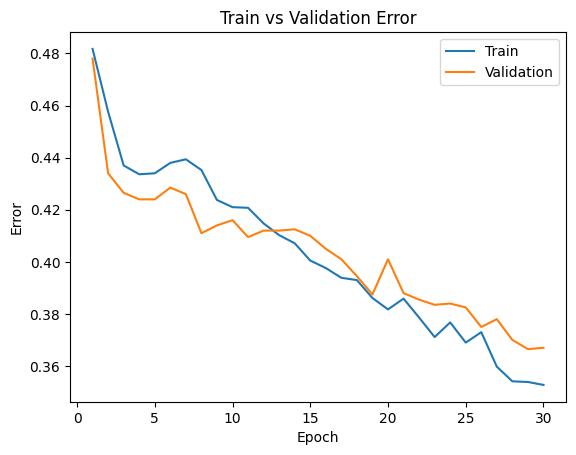

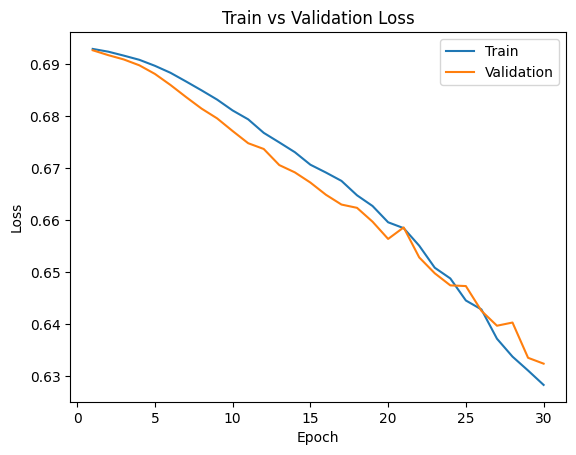

In [25]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)


Increasing the batch size made training faster overall, since fewer batches are needed to go through the dataset each epoch. However, the model learned more slowly, as shown by the gradual drop in both training and validation loss. Larger batches produce more stable updates but provide fewer updates per epoch, which can lead to slower learning and possible underfitting.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [26]:
large_net=LargeNet()
train_net(large_net, batch_size=16)

Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err: 0.326, Validation loss: 0.6016001827716827
Epoch 9: Train err: 0.249375, Tr

Total time elapsed: 202.92 seconds


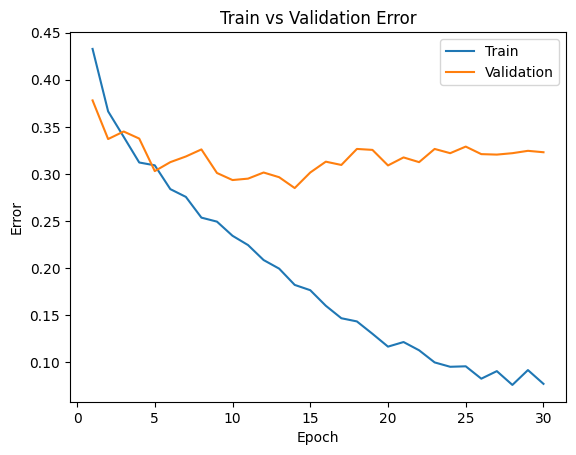

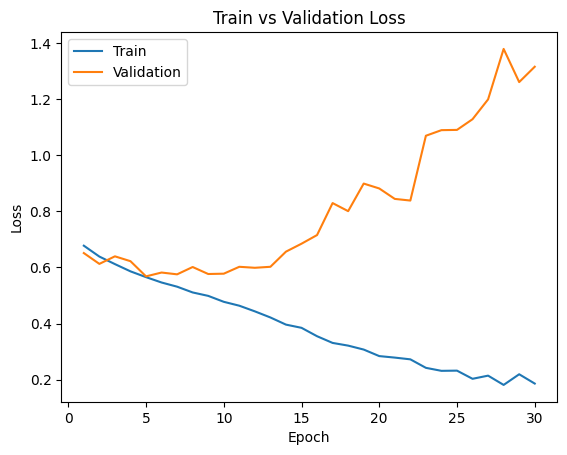

In [27]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Decreasing the batch size made the training take significantly longer. This is because the model had to process more batches per epoch.

From the training curve, we can see that training error and loss decreased sharply, showing that the model learned the training data well. However, validation loss increased steadily, and validation error flattened out. This is a sign of overfitting, where the model became too good at fitting the training set and failed to generalize to new data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

- Network: LargeNet
- Batch size: 64
- Learning rate: 0.001

Lowering the learning rate helped reduce overshooting and may improve validation accuracy over more epochs. The batch size of 64 balances speed and update frequency well, and LargeNet provides enough model capacity to capture complex features without underfitting.

From the previous experiments, LargeNet consistently showed stronger performance than SmallNet, with better training results and lower error. While using a high learning rate (0.1) or a small batch size (16) caused overfitting or instability, and large batch sizes (512) slowed learning, the combination of a moderate batch size (64) with a lower learning rate (0.001) showed smooth and stable training curves.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [28]:
large_net=LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001)

Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 0.4115, Validation loss: 0.6831991244107485
Epoch 9: Train err: 0.424375, Tr

Total time elapsed: 143.44 seconds



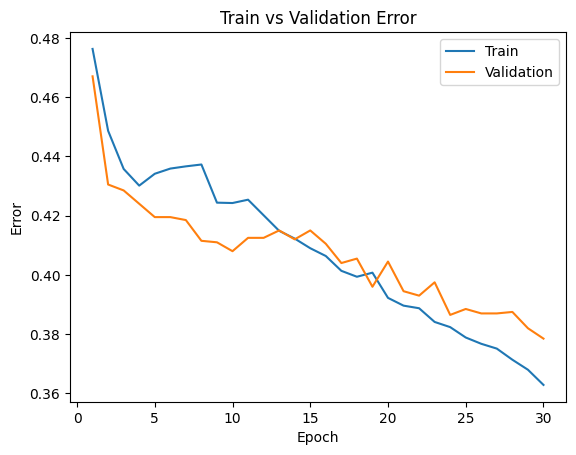

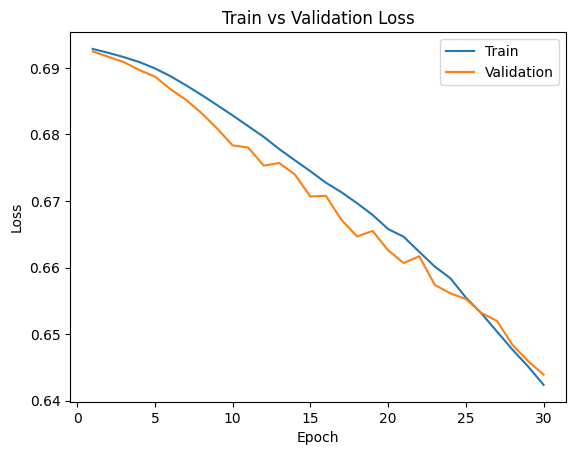

In [29]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

- Network: LargeNet
- Batch size: 64
- Learning rate: 0.001
- Epochs: 50

In Part 4(b), the training and validation curves were still decreasing at the end of 30 epochs, suggesting the model had not yet fully converged. To let the model continue learning and reduce error further, increasing the number of training epochs to 50 allows more time for optimization.

Others remain unchanged from part b)

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [30]:
large_net=LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=50)

Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 0.4115, Validation loss: 0.6831991244107485
Epoch 9: Train err: 0.424375, Tr

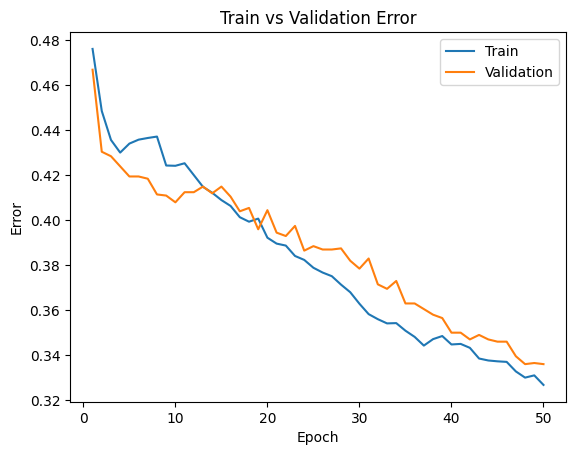

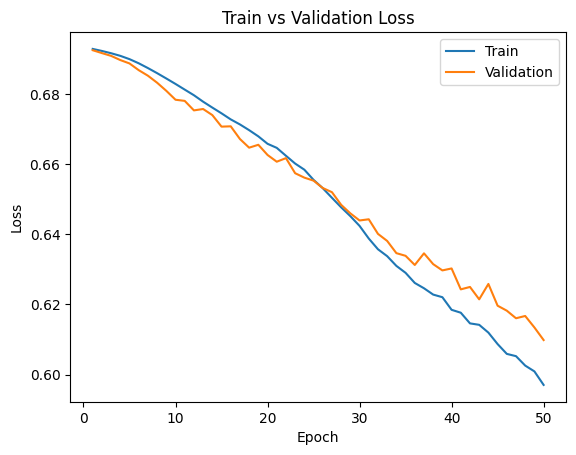

In [31]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=49)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [33]:
net = LargeNet()
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=49)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

This model gave the best validation performance across all experiments. The training and validation loss/error curves were smooth and continued improving throughout the 50 epochs, with no signs of overfitting.
- `LargeNet`: Its larger capacity allowed it to capture more complex image features, leading to lower error without overfitting.
-  Batch size = 64: This batch size provided a good trade-off between speed and learning quality. Smaller batches like 16 caused overfitting and took much longer to train, while very large batches like 512 slowed down learning and led to higher validation loss
- Learning rate = 0.001: This lower learning rate helped stabilize training. Higher values like 0.1 caused overshooting and high validation loss.
- Epoch = 49: I chose the last epoch of the 50-epoch run because the validation loss and error were still improving at that point, with no signs of overfitting.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [35]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

# Use same loss function as in training
criterion = nn.BCEWithLogitsLoss()

# Evaluate on test set
test_err, test_loss = evaluate(net, test_loader, criterion)

print(f"Test Classification Error: {test_err:}")

Test Classification Error: 0.3385


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

- Validation error: 0.336

- Test Classification Error: 0.3385

The test classification error is slightly higher than the validation error from training. This is expected because the test set contains completely unseen data that was never used to tune the model. In contrast, the validation set was used during training to monitor performance and select the best checkpoint, so the model is slightly more optimized for it.


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only used the test dataset at the very end to get an honest estimate of how well the model performs on truly unseen data. During training, we tune the model using the training and validation sets, which means the model indirectly "sees" those datasets. If we used the test set earlier, we might accidentally tune the model to perform well on it, leading to overfitting on the test data.

Using the test set only once at the end helps ensure that our evaluation is unbiased. It reflects how the model would perform in the real world, where the data is new and not part of the development process.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [36]:
class ANNNet(nn.Module):
    def __init__(self):
        super(ANNNet, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)             # flatten RGB image
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x


In [38]:
ann_net = ANNNet()
train_net(ann_net, batch_size=64, learning_rate=0.001, num_epochs=50)


Epoch 1: Train err: 0.4245, Train loss: 0.6744818654060364 |Validation err: 0.392, Validation loss: 0.6667892206460238
Epoch 2: Train err: 0.401125, Train loss: 0.6629457387924195 |Validation err: 0.3985, Validation loss: 0.6640852019190788
Epoch 3: Train err: 0.39425, Train loss: 0.6595642890930176 |Validation err: 0.384, Validation loss: 0.6602975241839886
Epoch 4: Train err: 0.386375, Train loss: 0.656307888507843 |Validation err: 0.4125, Validation loss: 0.6675748489797115
Epoch 5: Train err: 0.383875, Train loss: 0.6550839858055115 |Validation err: 0.392, Validation loss: 0.6630137953907251
Epoch 6: Train err: 0.3765, Train loss: 0.6513835692405701 |Validation err: 0.3875, Validation loss: 0.6625748611986637
Epoch 7: Train err: 0.374625, Train loss: 0.6504497723579407 |Validation err: 0.394, Validation loss: 0.6636239439249039
Epoch 8: Train err: 0.373125, Train loss: 0.6476472272872925 |Validation err: 0.3905, Validation loss: 0.6623242814093828
Epoch 9: Train err: 0.369375, Trai

**Best CNN performance**: validation error = 0.336

**ANN performance for this model**: validation error = 0.3845


### Increase hidden size


In [40]:
class ANNNet(nn.Module):
    def __init__(self):
        super(ANNNet, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)  # Increasing hidden size
        self.fc2 = nn.Linear(1024, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x



In [41]:
ann_net = ANNNet()
train_net(ann_net, batch_size=64, learning_rate=0.001, num_epochs=50)


Epoch 1: Train err: 0.426875, Train loss: 0.6746022868156433 |Validation err: 0.3915, Validation loss: 0.6630920115858316
Epoch 2: Train err: 0.400375, Train loss: 0.6627683715820313 |Validation err: 0.3855, Validation loss: 0.661514425650239
Epoch 3: Train err: 0.392625, Train loss: 0.6593123278617858 |Validation err: 0.3815, Validation loss: 0.6580317299813032
Epoch 4: Train err: 0.388375, Train loss: 0.6557765383720398 |Validation err: 0.4125, Validation loss: 0.6664979550987482
Epoch 5: Train err: 0.38125, Train loss: 0.6544400601387024 |Validation err: 0.3915, Validation loss: 0.6609121393412352
Epoch 6: Train err: 0.37725, Train loss: 0.6504847102165222 |Validation err: 0.3935, Validation loss: 0.6607725862413645
Epoch 7: Train err: 0.374875, Train loss: 0.6496826629638672 |Validation err: 0.4005, Validation loss: 0.6619305331259966
Epoch 8: Train err: 0.369875, Train loss: 0.646593120098114 |Validation err: 0.3875, Validation loss: 0.6608642786741257
Epoch 9: Train err: 0.36625,

**Best CNN performance**: validation error = 0.336

**ANN performance for this model**: validation error = 0.3795


### Change activation function to ReLU

In [49]:
class ANNNet(nn.Module):
    def __init__(self):
        super(ANNNet, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))    # change
        x = self.fc2(x)
        x = x.squeeze(1)
        return x



In [50]:
ann_net = ANNNet()
train_net(ann_net, batch_size=64, learning_rate=0.001, num_epochs=50)

Epoch 1: Train err: 0.425375, Train loss: 0.675906943321228 |Validation err: 0.406, Validation loss: 0.6635624915361404
Epoch 2: Train err: 0.391, Train loss: 0.6573760137557983 |Validation err: 0.394, Validation loss: 0.6572280246764421
Epoch 3: Train err: 0.37675, Train loss: 0.6479083671569824 |Validation err: 0.388, Validation loss: 0.6528409775346518
Epoch 4: Train err: 0.36775, Train loss: 0.6404098563194275 |Validation err: 0.3815, Validation loss: 0.6509985476732254
Epoch 5: Train err: 0.361, Train loss: 0.6345288910865784 |Validation err: 0.3755, Validation loss: 0.647982956841588
Epoch 6: Train err: 0.350625, Train loss: 0.6280080623626709 |Validation err: 0.3705, Validation loss: 0.6454473547637463
Epoch 7: Train err: 0.345375, Train loss: 0.6227965426445007 |Validation err: 0.372, Validation loss: 0.6447256971150637
Epoch 8: Train err: 0.33675, Train loss: 0.6172774157524109 |Validation err: 0.373, Validation loss: 0.6412331014871597
Epoch 9: Train err: 0.33375, Train loss:

**Best CNN performance**: validation error = 0.336

**ANN performance for this model**: validation error = 0.3445


### Adding a hidden layer

In [52]:
class ANNNet(nn.Module):
    def __init__(self):
        super(ANNNet, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)   # input → 1st hidden layer
        self.fc2 = nn.Linear(1024, 512)           # 1st hidden → 2nd hidden
        self.fc3 = nn.Linear(512, 1)              # 2nd hidden → output

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)               # flatten RGB image
        x = F.relu(self.fc1(x))               # activation 1
        x = F.relu(self.fc2(x))               # activation 2
        x = self.fc3(x)
        x = x.squeeze(1)
        return x


In [53]:
ann_net = ANNNet()
train_net(ann_net, batch_size=64, learning_rate=0.001, num_epochs=50)

Epoch 1: Train err: 0.426, Train loss: 0.68660573387146 |Validation err: 0.4165, Validation loss: 0.681540111079812
Epoch 2: Train err: 0.402375, Train loss: 0.6761292977333069 |Validation err: 0.417, Validation loss: 0.6730142291635275
Epoch 3: Train err: 0.39825, Train loss: 0.6678630833625794 |Validation err: 0.411, Validation loss: 0.6677337568253279
Epoch 4: Train err: 0.39425, Train loss: 0.6613557357788086 |Validation err: 0.401, Validation loss: 0.6619573831558228
Epoch 5: Train err: 0.388875, Train loss: 0.6559931769371032 |Validation err: 0.3955, Validation loss: 0.6606765501201153
Epoch 6: Train err: 0.38425, Train loss: 0.650773919582367 |Validation err: 0.3955, Validation loss: 0.6577093284577131
Epoch 7: Train err: 0.3765, Train loss: 0.6457831358909607 |Validation err: 0.3895, Validation loss: 0.6549847479909658
Epoch 8: Train err: 0.366375, Train loss: 0.6407851357460022 |Validation err: 0.384, Validation loss: 0.6510226745158434
Epoch 9: Train err: 0.36425, Train loss:

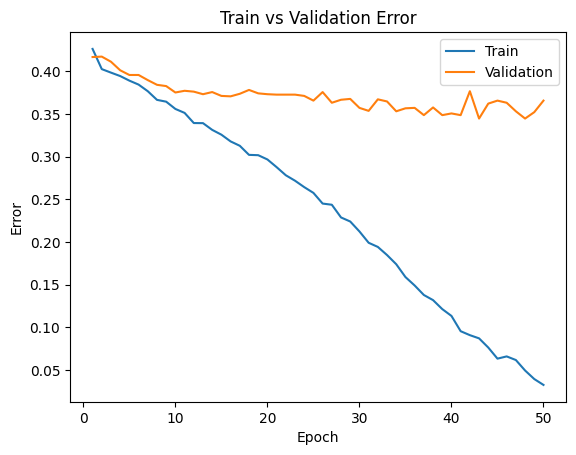

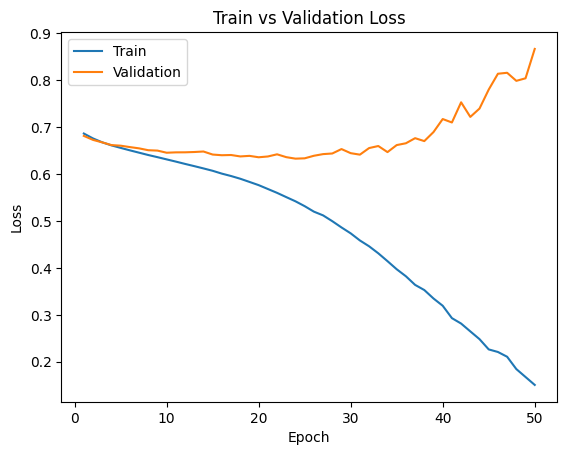

In [54]:
model_path = get_model_name("ann", batch_size=64, learning_rate=0.001, epoch=49)
plot_training_curve(model_path)

**Best CNN performance**: validation error = 0.336

**ANN performance for this model**: validation error = 0.3445


### Test on test data

In [57]:
test_err, _ = evaluate(ann_net, test_loader, criterion)
print("ANN Test Error:", test_err)


ANN Test Error: 0.3615


### Comparison Between Best CNN and ANN

My best CNN model achieved a validation error of 0.336, while my best ANN achieved a validation error of 0.3445. The CNN clearly performed better.

My best CNN model achieved a validation error of 0.336 and a test classification error of 0.3385. In contrast, after hyperparameter tuning, the best ANN model achieved a validation error of 0.3445 and a test error of 0.3615.

This is expected because CNNs are specifically designed to capture spatial features and local patterns in images through convolutional filters and pooling, while ANNs treat each pixel independently. As a result, the ANN struggles to generalize well despite having more hidden units or layers.
